In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
        
input_path = Path('/kaggle/input/tabular-playground-series-mar-2021/')

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


## 1. Read in the data files

In [2]:
train = pd.read_csv(input_path / 'train.csv', index_col='id')
display(train.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,BI,A,S,Q,A,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [3]:
train.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16',
       'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

In [4]:
test = pd.read_csv(input_path / 'test.csv', index_col='id')
display(test.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,
5,A,F,A,A,F,BI,A,AH,AX,A,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
6,A,H,C,A,E,AB,I,F,N,A,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
8,A,N,C,A,F,AB,A,AH,BC,A,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
9,B,L,C,A,F,BI,A,E,AX,A,...,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
11,A,F,A,B,F,BI,A,AH,I,A,...,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [5]:
submission = pd.read_csv(input_path / 'sample_submission.csv', index_col='id')
display(submission.head())

,target
id,
5,0.5
6,0.5
8,0.5
9,0.5
11,0.5


## 2. Processing data

### 2.1 Check missing values

In [6]:
train.isnull().sum()

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64

In [7]:
test.isnull().sum()

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
dtype: int64

### 2.2 Numerical values 

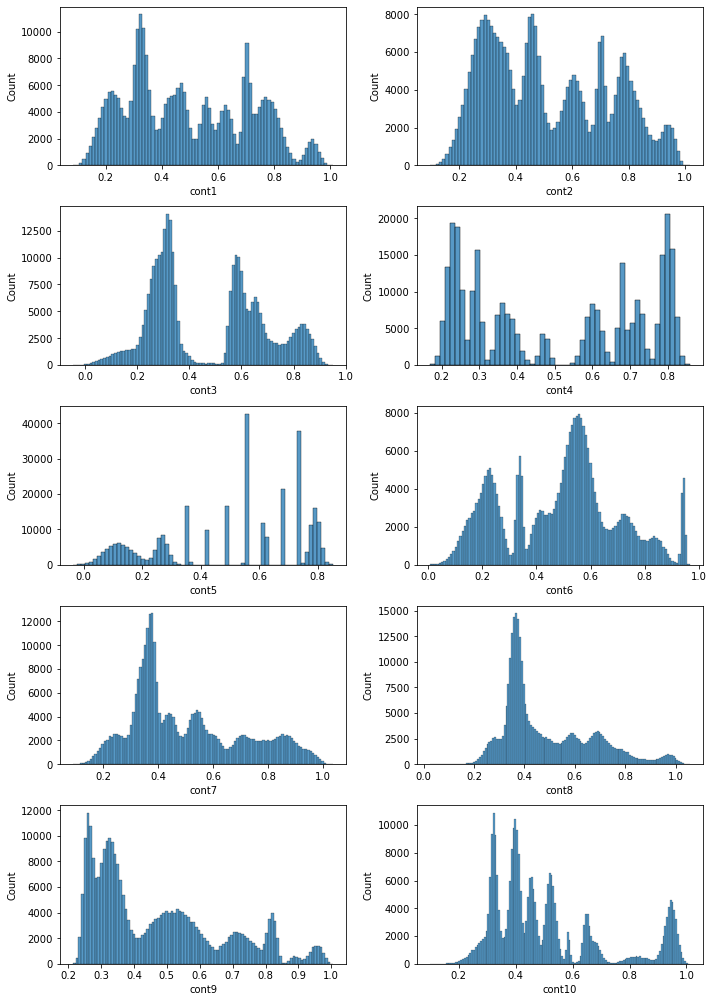

In [8]:
num_col = ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']
fig = plt.figure(figsize=(10,14))

for index, col in enumerate(num_col): 
    plt.subplot(5,2,index+1)
    sns.histplot(train[num_col[index]],kde=False)
fig.tight_layout(pad=1.0)

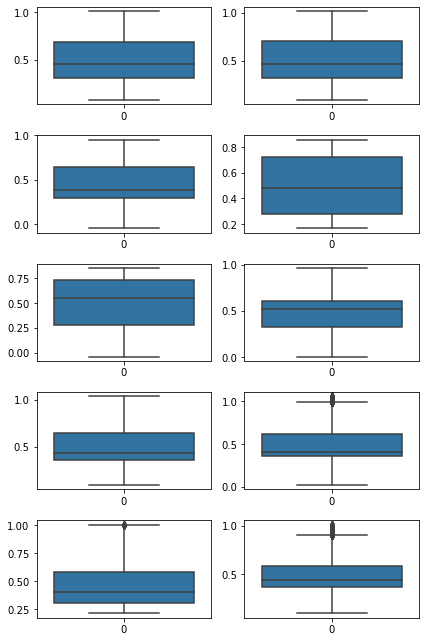

In [9]:
fig = plt.figure(figsize=(6,9))

for index, col in enumerate(num_col): 
    plt.subplot(5,2,index+1)
    sns.boxplot(data = train[num_col[index]])
fig.tight_layout(pad=1.0)

### 2.3 Categorical columns

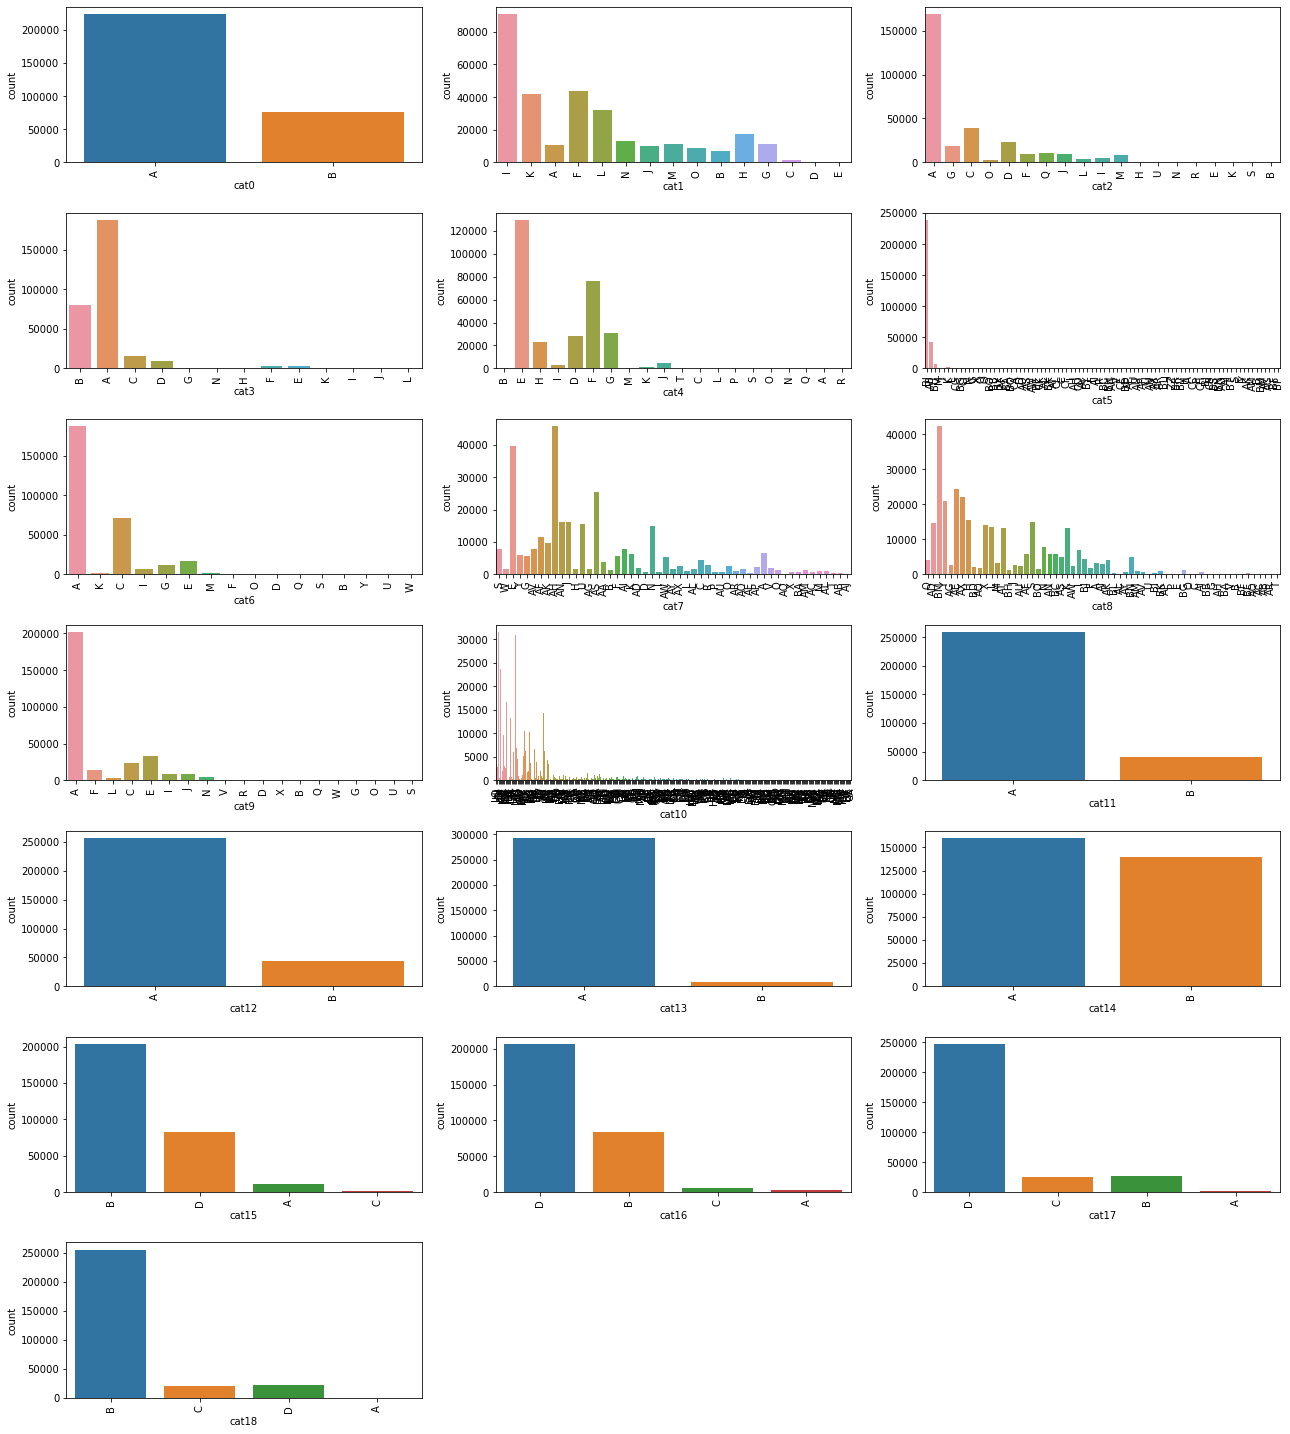

In [10]:
cat_col = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8','cat9', 
           'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

fig = plt.figure(figsize=(18,20))
for index in range(len(cat_col)):
    plt.subplot(7,3,index+1)
    sns.countplot(x=train[cat_col[index]], data=train[cat_col[index]])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

In [11]:
# Check data leakage between train and test dataset

for index in range(len(cat_col)):
    train_value = train[cat_col[index]].unique()
    test_value = test[cat_col[index]].unique()
    if set(train_value) == set(test_value):
        print('cat{}：yes!'.format(index))
    else:
        print('cat{}：no!'.format(index))

cat0：yes!
cat1：yes!
cat2：yes!
cat3：yes!
cat4：yes!
cat5：yes!
cat6：yes!
cat7：yes!
cat8：yes!
cat9：yes!
cat10：no!
cat11：yes!
cat12：yes!
cat13：yes!
cat14：yes!
cat15：yes!
cat16：yes!
cat17：yes!
cat18：yes!


In [12]:
# Drop column 'cat10'

train.drop('cat10', axis = 1, inplace = True)
test.drop('cat10', axis = 1, inplace = True)

In [13]:
cat_col.remove('cat10')

In [14]:
# Remove values with counts less than 1000

def rmv_vl(df, col_name):
    """
    remove values with counts less than 1000
    
    Input: 
    df: dataframe
    col_name
    
    Output:
    df: dataframe    
    """
    size_tol = df[col_name].shape[0]/300
    index_list = df[col_name].value_counts().reset_index(name="count").query('count< @size_tol')['index']
    df.loc[df[col_name].isin (index_list),col_name] = 'others'
    return df[col_name]

In [15]:
for col_name in cat_col:
    train.loc[col_name] = rmv_vl(train, col_name)
    test.loc[col_name] = rmv_vl(test, col_name)

In [16]:
train.dropna(inplace = True)
test.dropna(inplace = True)

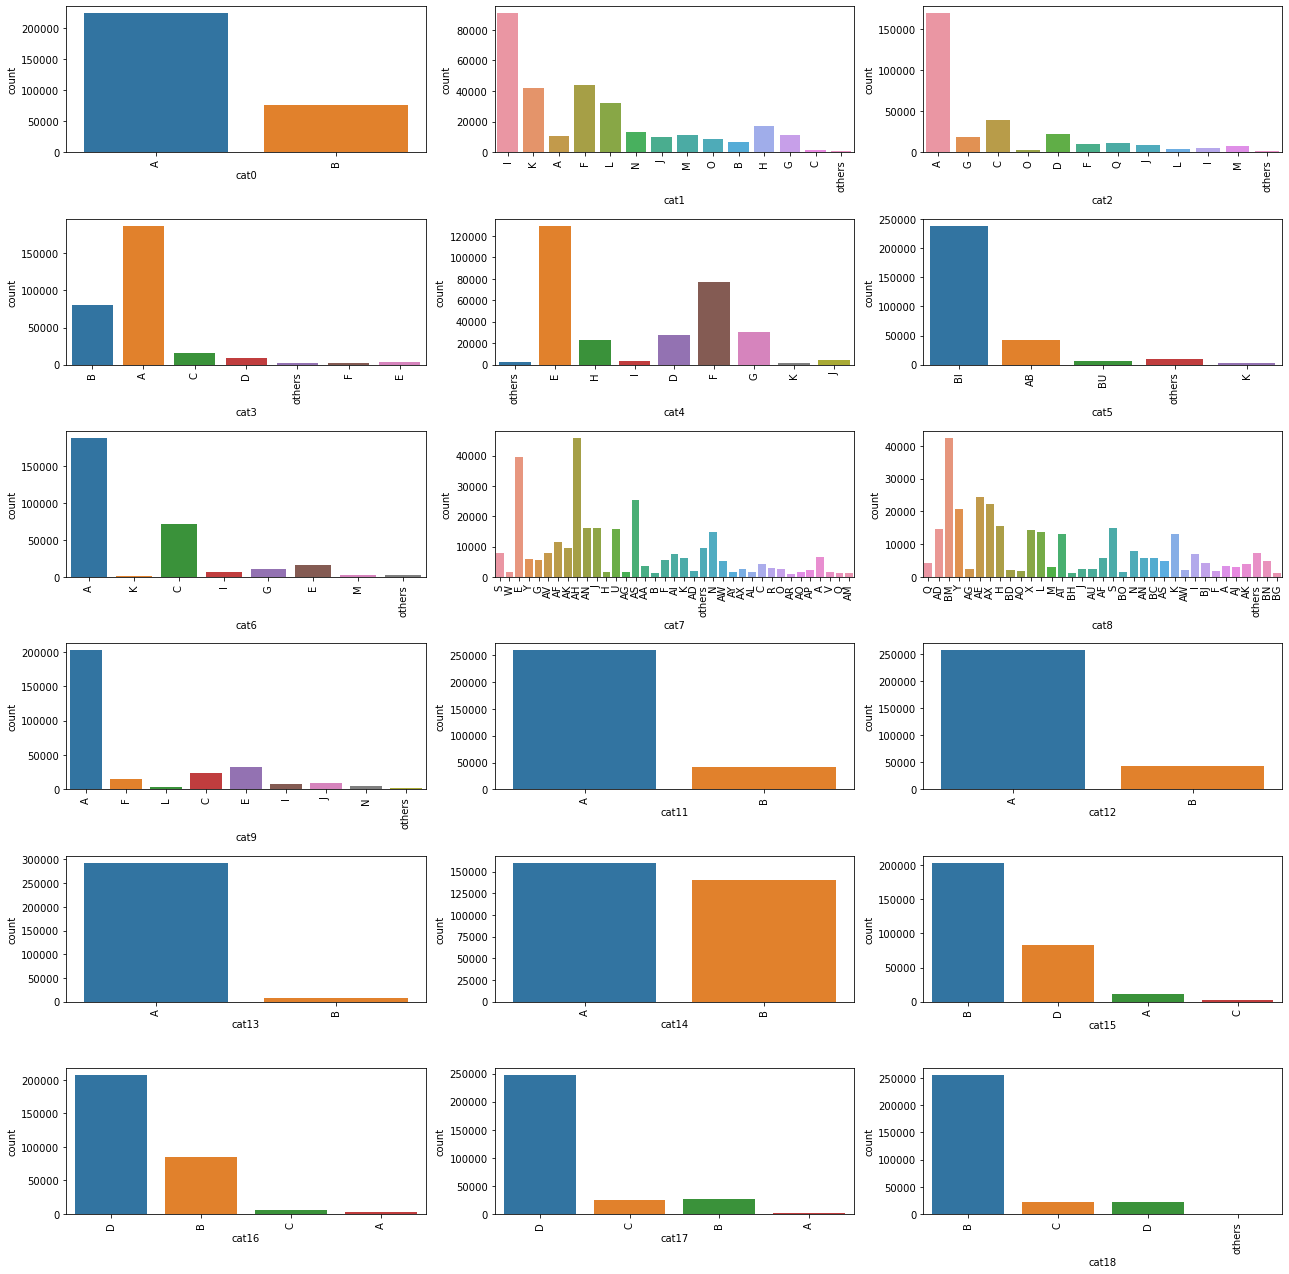

In [17]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_col)):
    plt.subplot(7,3,index+1)
    sns.countplot(x=train[cat_col[index]], data=train[cat_col[index]])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

Based on the different distribution of each column, following actions are implemented: 

- **OneHotEncoder**: cat0, cat3, cat4, cat5, cat6, cat9, cat11, cat12, cat13, cat14, cat15, cat16, cat17, cat18
- **LaberEncoder**: cat1, cat2, cat7, cat8

In [18]:
cat_col_lb = ['cat1', 'cat2', 'cat7', 'cat8']
cat_col_ohe = list(set(cat_col) - set(cat_col_lb))

In [19]:
for c in cat_col_lb:
    lbl = LabelEncoder()
    lbl.fit(list(train[c].values) + list(test[c].values))
    train[c] = lbl.transform(train[c].values)
    test[c] = lbl.transform(test[c].values)
        
display(train.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
0,A,6,0,B,others,BI,A,32,31,A,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0.0
1,A,6,0,A,E,BI,K,35,1,F,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0.0
2,A,8,0,A,E,BI,A,21,20,L,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0.0
3,A,8,0,C,E,BI,A,36,1,F,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0.0
4,A,6,4,B,E,BI,C,23,31,A,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1.0


In [20]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(pd.concat([train[cat_col_ohe], test[cat_col_ohe]], axis = 0))
ohe_train = pd.DataFrame(ohe.transform(train[cat_col_ohe]))
ohe_train.index = train.index
ohe_test = pd.DataFrame(ohe.transform(test[cat_col_ohe]))
ohe_test.index = test.index
display(ohe_train.head())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
train_final = pd.concat([train.drop(cat_col_ohe,axis = 1), ohe_train],axis = 1)
test_final = pd.concat([test.drop(cat_col_ohe,axis = 1), ohe_test],axis = 1)

## Pull out the target, and make a validation split

In [22]:
y = train_final.pop('target')
X_train, X_test, y_train, y_test = train_test_split(train_final, y, train_size=0.70)

XGBost


In [23]:
from xgboost import XGBClassifier
my_model = XGBClassifier(eval_metric = 'auc', 
                         random_state = 42,
                         use_label_encoder = False,
                         n_estimators=10000, 
                         learning_rate=0.01, 
                         n_jobs=-1)

my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)
y_pred = my_model.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, y_pred)
print(f'{score:0.5f}') # 0.87323 shows we're doing better than a dummy model

0.88820


In [24]:
submission['target'] = my_model.predict_proba(test_final)[:, 1]
submission.to_csv('random_forest8.csv')